# INIT

## load pack

In [1]:
import sys
sys.path.append("../POS_tagging/")
sys.path.append("../../../pomegranate/")
sys.path.append(r"../../../WhoCell\pomegranate")
sys.path.append(r"../../../WhoCell")
sys.path.append(r"../../../WhoCell/")
sys.path.append(r"../../../WhoCell/who_cell/")
sys.path.append(r"../../../WhoCell/who_cell/models/")
sys.path.append(r"../../../WhoCell/who_cell/simulation/")
sys.path.append(r"../../../WhoCell/who_cell/experiments/")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import string

from collections import Counter
from IPython.core.display import HTML
from itertools import chain
from collections import Counter, defaultdict
from helpers import show_model, Dataset
import pandas as pd
import seaborn as sns
import itertools
from functools import reduce

from pomegranate import State, HiddenMarkovModel, DiscreteDistribution

from simulation_for_gibbs import Simulator_for_Gibbs
from gibbs_sampler import GibbsSampler
from experiment_report import ExperimentReport 
from gibbs_experiments import GibbsExperiment
from pos_data_builder import PosDataBuilder
from pos_code_base import PosCodeBase


In [3]:
%connect_info
%load_ext autoreload

import warnings
warnings.filterwarnings('ignore')

{
  "shell_port": 58869,
  "iopub_port": 56901,
  "stdin_port": 48109,
  "control_port": 59431,
  "hb_port": 40177,
  "ip": "127.0.0.1",
  "key": "103b3683-04b8ee7faee19b95c4c0bd2d",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-a1a68387-8c76-44a8-b230-39f27618d081.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


## load experiments sets

In [4]:
data_builder = PosDataBuilder()
code_base = PosCodeBase()

# Build experiment 

The experiment details -   

Our data :   
1)Training data : labeled sentences
2)Test set - the same

Experiment :  
1)We will use the training set labels for few observations Markov chain - not hidden! by using the states labels as emissions.  
2)Then we learn the emissions from the training set  
3)We will predict the labels on the test set   



In [5]:
pc = 0.5

test_set_words, test_set_tags = data_builder.get_experiment_sets_from_real_data(pc,False)
all_states = data_builder._build_emissions_probabilites().keys()

In [6]:
transitions_probs,transitions_probs_df = data_builder.get_known_transitions()

In [7]:
i=0
training_tags = [] 
for _,sen in data_builder.row_data.sentences.items() : 
    training_tags.append(list(sen.tags))
    i += 1
    if i > 20000 : 
        break

## Learning without "few observations" 

In [8]:
emm_probs = {state:{state:1} for state in all_states}


In [9]:
first_experiment_args = {"test_set_words":training_tags,
"start_probs":data_builder._build_starting_probabilites(),
"emms_probs":emm_probs,
"number_of_iters":35,
"N":2,
"is_only_observed":False,
"description":"P(C) = 1",
"known_transitions":None,
"comper_transitions":None,
"comper_transitions_title" :None,
"state_order_for_plot":data_builder.STATE_ORDER_TO_PLOT,
"title":"Naive MM"}
first_experiment_results = code_base.run_pos_experiment(**first_experiment_args)

start M-H sampling


100%|████████████████████████████████████████| 35/35 [1:09:58<00:00, 119.96s/it]


## learning when the expected trajectory is twice the length

In [10]:
_known_N = [2*len(seq) for seq in training_tags]

In [11]:
second_experiment_args = {"test_set_words":training_tags,
"start_probs":data_builder._build_starting_probabilites(),
"emms_probs":emm_probs,
"number_of_iters":35,
"N":_known_N,
"is_only_observed":False,
"description":"P(C) = 1",
"known_transitions":None,
"comper_transitions":None,
"comper_transitions_title" :None,
"state_order_for_plot":data_builder.STATE_ORDER_TO_PLOT,
"title":"few obs"}
second_experiment_results = code_base.run_pos_experiment(**second_experiment_args)

start M-H sampling


100%|████████████████████████████████████████| 35/35 [1:17:20<00:00, 132.60s/it]


## learning when the expected trajectory is twice the length only observed

In [12]:
third_experiment_args = {"test_set_words":training_tags,
"start_probs":data_builder._build_starting_probabilites(),
"emms_probs":emm_probs,
"number_of_iters":35,
"N":_known_N,
"is_only_observed":True,
"description":"P(C) = 1",
"known_transitions":None,
"comper_transitions":None,
"comper_transitions_title" :None,
"state_order_for_plot":data_builder.STATE_ORDER_TO_PLOT,
"title":"few obs only seen"}
third_experiment_results = code_base.run_pos_experiment(**third_experiment_args)

start M-H sampling


100%|████████████████████████████████████████| 35/35 [1:17:16<00:00, 132.48s/it]


# measures and plots

In [13]:
def build_pome_model_from_trnaisiotns(predicted_transitions,words_emms_probs,start_probs,all_states):
    states_name_to_state_mapping = {state:State(DiscreteDistribution(words_emms_probs[state]),state) for state in all_states}

    _model = HiddenMarkovModel()
    for _from,_tos in predicted_transitions.items() : 
        if _from == "start" : 
            for state in all_states : 
                _to_state = states_name_to_state_mapping[state]
                _model.add_transition(_model.start,_to_state,start_probs[_to])
            continue
        for _to,val in _tos.items() :
            if _to == 'end' : continue
            _to_state = states_name_to_state_mapping[_to]
            
            _from_state = states_name_to_state_mapping[_from]
            _model.add_transition(_from_state,_to_state,val)

    _model.bake()
    return _model

def calculate_error(predicted_transitions,test_set_words,test_set_tags,words_emms_probs,start_probs,all_states,unknown_words):
    pome_model = build_pome_model_from_trnaisiotns(predicted_transitions,words_emms_probs,start_probs,all_states)
    states_name_list = [state.name for state in pome_model.states]

    errors = []
    for sent_words,sent_tags in zip(test_set_words,test_set_tags) :
        sent_words = [(word if word not in unknown_words else None) for word in sent_words]
        _predicted = pome_model.predict(sent_words)
        predicted_tags = [states_name_list[i] for i in _predicted]
        error = sum([i!=j for i,j in zip(sent_tags,predicted_tags)])
        errors.append(error)
    return np.mean(errors)



In [14]:
words_emms_probs = data_builder._build_emissions_probabilites()

all_words_in_test_set = data_builder.row_data.vocab
all_known_words = frozenset(chain(*[val for val in words_emms_probs.values()]))
unknown_words = (all_words_in_test_set - all_known_words)

In [15]:
start_probs = data_builder._build_starting_probabilites()

In [16]:
transitions_results_list = [first_experiment_results['transitions'],second_experiment_results['transitions'],third_experiment_results['transitions']]
w_results_list = [first_experiment_results['ws']]
experiments_name_list = [first_experiment_args['title'],second_experiment_args['title'],third_experiment_args['title']]


all_results = {}
for _trans_list,exp_name in zip(transitions_results_list,experiments_name_list) : 
    _dist = [calculate_error(_t,test_set_words,test_set_tags,words_emms_probs,start_probs,all_states,unknown_words) for _t in _trans_list]
    
    all_results[exp_name] = _dist



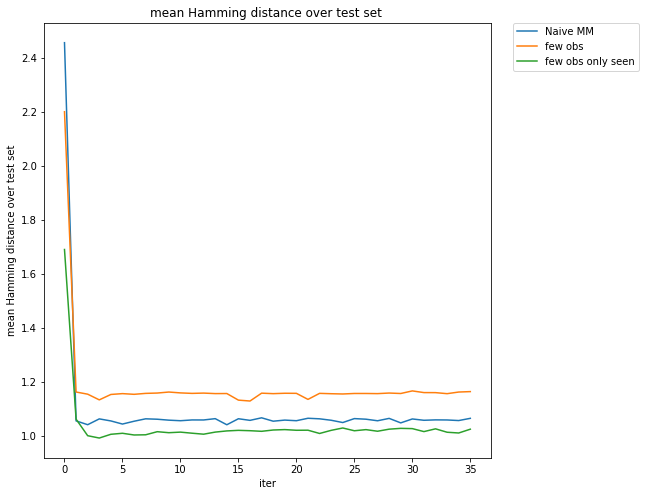

In [20]:
fig, sub = plt.subplots(1,1,figsize=(8, 8))
model_results_df = pd.DataFrame(all_results)

sns.lineplot(data=model_results_df, ax=sub, legend='full', dashes=False)
sub.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sub.set_title(f"mean Hamming distance over test set ")
sub.set_xlabel("iter")
sub.set_ylabel(f"mean Hamming distance over test set")

plt.subplots_adjust(hspace=0.8)
plt.subplots_adjust(wspace=0.8)

plt.show()